# Using text and neural network features

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/universal-sentence-encoder/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>


Welcome to the **Intermediate Colab** for **TensorFlow Decision Forests** (**TF-DF**).
In this colab, you will learn about some more advanced capabilities of **TF-DF**, including how to deal with natural language features.

This colab assumes you are familiar with the concepts presented the [Beginner colab](beginner_colab.ipynb), notably about the installation about TF-DF.

In this colab, you will:

1. Train a Random Forest that consumes text features natively as categorical sets.

1. Train a Random Forest that consumes text features using a [TensorFlow Hub](https://www.tensorflow.org/hub) module. In this setting (transfer learning), the module is already pre-trained on a large text corpus.

1. Train a Gradient Boosted Decision Trees (GBDT) and a Neural Network together. The GBDT will consume the output of the Neural Network.

## Setup

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.9.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.6 MB 4.6 MB/s 
     |████████████████████████████████| 511.8 MB 7.1 kB/s 
     |████████████████████████████████| 1.6 MB 73.0 MB/s 
     |████████████████████████████████| 438 kB 86.6 MB/s 
     |████████████████████████████████| 5.8 MB 71.6 MB/s 
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 71.9 MB/s 
     |████████████████████████████████| 352 kB 78.0 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 238 kB 72.4 MB/s 
     |████████████████████████████████| 1.1 MB 65.8 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 116 kB 72.9 MB/s 


In [2]:
# Install TensorFlow Dececision Forests
!pip install tensorflow_decision_forests==0.2.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 5.1 MB/s 


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [3]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the necessary libraries.

In [4]:
import tensorflow_decision_forests as tfdf

import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
from keras.callbacks import *

The hidden code cell limits the output height in colab.

In [5]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

## Use raw text as features

TF-DF can consume [categorical-set](https://arxiv.org/pdf/2009.09991.pdf) features natively. Categorical-sets represent text features as bags of words (or n-grams).

For example: `"The little blue dog" ` → `{"the", "little", "blue", "dog"}`

In this example, you'll will train a Random Forest on the [Threat Intelligence Reports](https://github.com/threatDataset) dataset. The objective of this dataset is to classify reports into 12 threat actors. You'll will use the multiclass classification version of the dataset.

**Note:** Categorical-set features can be expensive to train. In this colab, we will train a small Random Forest with 1000 trees.

In [7]:
# Load the dataset

url = 'https://github.com/eyalmazuz/AttackAttributionDataset/archive/refs/heads/master.zip' 

dataset = tf.keras.utils.get_file('master.zip', url, extract=True, cache_dir='.', cache_subdir='')


# Display the first 3 examples of the test fold.
# for example in train_ds.take(1):
#   print({attr_name: attr_tensor.numpy() for attr_name, attr_tensor in example.items()})

1248841/1248841 [==============================] - 0s 0us/step


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 5
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='validation',
    seed=seed)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 238 files belonging to 12 classes.
Using 203 files for training.
Found 238 files belonging to 12 classes.
Using 35 files for validation.



**Details:** Some decision forest learning algorithms do not need a validation dataset (e.g. Random Forests) while others do (e.g. Gradient Boosted Trees in some cases). Since each learning algorithm under TF-DF can use validation data differently, TF-DF handles train/validation splits internally. As a result, when you have a training and validation sets, they can always be concatenated as input to the learning algorithm.

Finaly, train and evaluate the model as usual. TF-DF  automatically detects multi-valued categorical features as categorical-set.


In [9]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=15000, verbose=2, check_dataset=False)
# Train the model.
history = model_1.fit(x=train_ds)

print(history.history.items())


<IPython.core.display.Javascript object>

Use /tmp/tmpwe8t8c08 as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None,), dtype=string)
Label: Tensor("data_1:0", shape=(None,), dtype=int32)
Weights: None
Normalized tensor features:
 {'data:0': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>)}
Training dataset read in 0:00:04.207239. Found 203 examples.
Training model...
Standard output detected as not visible to the user e.g. running in a notebook. Creating a training log redirection. If training get stuck, try calling tfdf.keras.set_training_logs_redirection(False).


[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 41
[INFO kernel.cc:423] Number of examples: 203
[INFO data_spec_inference.cc:303] 203 item(s) have been pruned (i.e. they are considered out of dictionary) for the column data:0 (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:836] Training dataset:
Number of records: 203
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 2 (100%)

Columns:

CATEGORICAL: 2 (100%)
	0: "data:0" CATEGORICAL has-dict vocab-size:1 num-oods:203 (100%)
	1: "__LABEL" CATEGORICAL integerized vocab-size:13 no-ood-item

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained through tokenization.
	has-dict: The attribute is a

Model trained in 0:00:00.458933
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
dict_items([('num_examples', [203]), ('accuracy', [0.24630541871921183]), ('loss', [22.996119845089655])])


In [10]:
model_gb_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=15000, check_dataset=False)


history_gb = model_gb_1.fit(x=train_ds)

print(history_gb.history.items())

Use /tmp/tmpmz3gqm3z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132905. Found 203 examples.
Training model...
Model trained in 0:00:00.199342
Compiling model...
Model compiled.
dict_items([('accuracy', [0.20000000298023224]), ('loss', [2.440039873123169])])


In the previous logs, note that `sentence` is a `CATEGORICAL_SET` feature.

The model is evaluated as usual:

In [11]:
model_1.compile(metrics=["Accuracy"])
evaluation = model_1.evaluate(test_ds)
print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
model_1.make_inspector().evaluation()




7/7 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - Accuracy: 0.1429
loss: 0.0
Accuracy: 0.1428571492433548


Evaluation(num_examples=203, accuracy=0.24630541871921183, loss=22.996119845089655, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [12]:
model_gb_1.compile(metrics=["Accuracy"])
evaluation = model_gb_1.evaluate(test_ds)
print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
model_gb_1.make_inspector().evaluation()

7/7 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - Accuracy: 0.1429
loss: 0.0
Accuracy: 0.1428571492433548


Evaluation(num_examples=None, accuracy=0.20000000298023224, loss=2.434854030609131, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [13]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=3, max_depth=300)


In [14]:
tfdf.model_plotter.plot_model_in_colab(model_gb_1, tree_idx=0, max_depth=300)


In [15]:
model_1.make_inspector().variable_importances()

{'MEAN_MIN_DEPTH': [("data:0" (4; #0), 0.0), ("__LABEL" (4; #1), 0.0)],
 'SUM_SCORE': [],
 'NUM_NODES': [],
 'NUM_AS_ROOT': []}

The training logs looks are follow:

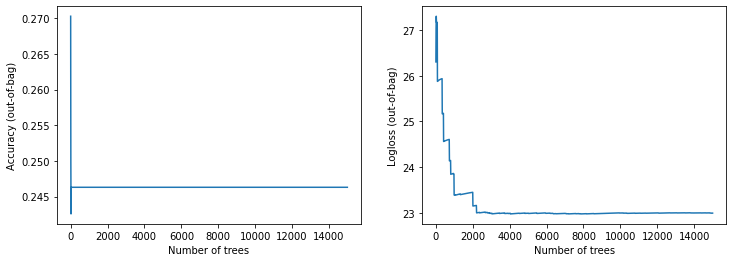

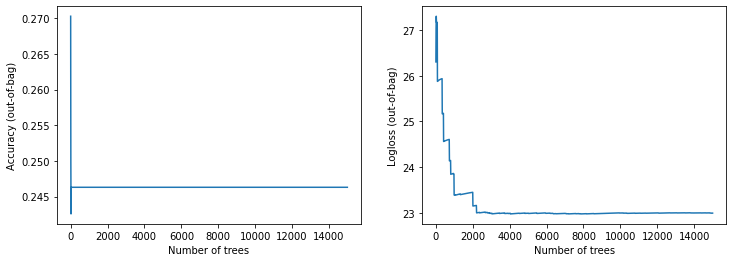

In [16]:
import matplotlib.pyplot as plt
# Plotting random forrest results
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# plotting gradient boosted results
logs_gb = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()
pass

More trees would probably be beneficial (I am sure of it because I tried :p).

## Use a pretrained text embedding

The previous example trained a Random Forest using raw text features. This example will use a pre-trained TF-Hub embedding to convert text features into a dense embedding, and then train a Random Forest on top of it. In this situation, the Random Forest will only "see" the numerical output of the embedding (i.e. it will not see the raw text). 

In this experiment,  will use the [Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4). Different pre-trained embeddings might be suited for different types of text (e.g. different language, different task) but also for other type of structured features (e.g. images).

**Note:** This embedding is large (1GB) and therefore the final model will be slow to run (compared to classical decision tree inference).

The embedding module can be applied in one of two places:

1. During the dataset preparation.
2. In the pre-processing stage of the model.

The second option is often preferable: Packaging the embedding in the model makes the model easier to use (and harder to misuse).

First install TF-Hub:

In [17]:
!pip install --upgrade tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Unlike before, you don't need to tokenize the text.

In [18]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : example["sentence"]}, label

# train_ds = all_ds["train"].batch(100).map(prepare_dataset)
# test_ds = all_ds["validation"].batch(100).map(prepare_dataset)


In [19]:
%set_cell_height 300

import tensorflow_hub as hub
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer(hub_url)

inputs = tf.keras.layers.Input(shape=(), name="input", dtype=tf.string)
embedded_inputs = embedding(inputs)

raw_inputs = {"input": inputs}
processed_inputs = {"embedded_reports": embedded_inputs}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    check_dataset=False,
    num_trees=15000)


<IPython.core.display.Javascript object>

Use /tmp/tmp1nugbyhw as temporary training directory


In [20]:
model_gb_2 = tfdf.keras.GradientBoostedTreesModel(
    preprocessing=preprocessor,
    check_dataset=False,
    num_trees=15000)

Use /tmp/tmpbo3ayrd6 as temporary training directory


In [21]:
history = model_2.fit(x=train_ds)
print(history.history.items())

Reading training dataset...
Training dataset read in 0:00:07.032379. Found 203 examples.
Training model...
Model trained in 0:00:15.493283
Compiling model...
Model compiled.
dict_items([('num_examples', [203]), ('accuracy', [0.41379310344827586]), ('loss', [1.8973925005038972])])


In [22]:
history_gb = model_gb_2.fit(x=train_ds)
print(history.history.items())

Reading training dataset...
Training dataset read in 0:00:06.678532. Found 203 examples.
Training model...
Model trained in 0:00:01.892262
Compiling model...
Model compiled.
dict_items([('num_examples', [203]), ('accuracy', [0.41379310344827586]), ('loss', [1.8973925005038972])])


In [23]:
model_2.summary()


Streaming output truncated to the last 5000 lines.
  106. "embedded_reports.321" 13885.191654 ##
  107.  "embedded_reports.81" 13793.999358 ##
  108. "embedded_reports.377" 13772.928771 ##
  109.  "embedded_reports.12" 13750.965713 ##
  110. "embedded_reports.485" 13683.244504 ##
  111. "embedded_reports.306" 13668.504846 ##
  112. "embedded_reports.158" 13641.369281 ##
  113. "embedded_reports.151" 13529.989142 ##
  114. "embedded_reports.501" 13501.807071 ##
  115. "embedded_reports.504" 13484.001943 ##
  116. "embedded_reports.244" 13432.120569 ##
  117. "embedded_reports.472" 13416.656452 ##
  118.  "embedded_reports.22" 13410.220649 ##
  119.  "embedded_reports.61" 13393.352204 ##
  120.  "embedded_reports.53" 13373.628571 ##
  121. "embedded_reports.438" 13368.662675 ##
  122. "embedded_reports.395" 13344.292129 ##
  123. "embedded_reports.296" 13281.431557 ##
  124.  "embedded_reports.91" 13059.062053 ##
  125. "embedded_reports.473" 13028.315238 ##
  126. "embedded_reports.398"

In [24]:
model_2.compile(metrics=["Accuracy"])
evaluation = model_2.evaluate(test_ds)
print(evaluation)

print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

7/7 [==============================] - 2s 43ms/step - loss: 0.0000e+00 - Accuracy: 0.2571
[0.0, 0.2571428716182709]
loss: 0.0
Accuracy: 0.2571428716182709


In [25]:
model_gb_2.compile(metrics=["Accuracy"])
evaluation = model_gb_2.evaluate(test_ds)
print(evaluation)

print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

7/7 [==============================] - 2s 31ms/step - loss: 0.0000e+00 - Accuracy: 0.2286
[0.0, 0.22857142984867096]
loss: 0.0
Accuracy: 0.22857142984867096


Note that categorical sets represent text differently from a dense embedding, so it may be useful to use both strategies jointly.

## Train a decision tree and neural network together

The previous example used a pre-trained Neural Network (NN) to 
process the text features before passing them to the Random Forest. This example will train both the Neural Network and the Random Forest from scratch.


TF-DF's Decision Forests do not back-propagate gradients ([although this is the subject of ongoing research](https://arxiv.org/abs/2007.14761)). Therefore, the training happens in two stages:

1. Train the neural-network as a standard classification task:

```
example → [Normalize] → [Neural Network*] → [classification head] → prediction
*: Training.
```

2. Replace the Neural Network's head (the last layer and the soft-max) with a Random Forest. Train the Random Forest as usual:

```
example → [Normalize] → [Neural Network] → [Random Forest*] → prediction
*: Training.
```



### Prepare the dataset



### Build the models

Next create the neural network model using [Keras' functional style](https://www.tensorflow.org/guide/keras/functional). 

Bring back that Functional model from BERT

In [26]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 100000
sequence_length = 1000

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

Build the body of the neural network:

In [27]:
embedding_dim=336

nn_model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(320, activation="tanh"),
  Dense(118, activation="relu"),
  tf.keras.layers.Dropout(0.25),
  Dense(112, activation="tanh"),
  tf.keras.layers.Dropout(0.15),  
  Dense(94, activation='tanh'),
  Dense(len(class_names))
])

# y = tf.keras.layers.Concatenate()(nn_processed_inputs)
# y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(nn_raw_inputs)
# last_layer = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)

# "3" for the three label classes. If it were a binary classification, the
# output dim would be 1.
# classification_output = tf.keras.layers.Dense(12)(y)

# nn_model = tf.keras.models.Model(nn_raw_inputs, classification_output)

This `nn_model` directly produces classification logits. 

Next create a decision forest model. This will operate on the high level features that the neural network extracts in the last layer before that classification head.

### Train and evaluate the models

The model will be trained in two stages. First train the neural network with its own classification head:

In [28]:
%set_cell_height 300

nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

nn_model.fit(x=train_ds, validation_data=test_ds, epochs=15)
nn_model.summary()

<IPython.core.display.Javascript object>

Epoch 1/15
41/41 [==============================] - 7s 164ms/step - loss: 2.3934 - accuracy: 0.2069 - val_loss: 2.4069 - val_accuracy: 0.1714
Epoch 2/15
41/41 [==============================] - 6s 157ms/step - loss: 2.1327 - accuracy: 0.3744 - val_loss: 2.4960 - val_accuracy: 0.2000
Epoch 3/15
41/41 [==============================] - 6s 156ms/step - loss: 1.6174 - accuracy: 0.5320 - val_loss: 2.0529 - val_accuracy: 0.2857
Epoch 4/15
41/41 [==============================] - 6s 157ms/step - loss: 1.5061 - accuracy: 0.5369 - val_loss: 3.1223 - val_accuracy: 0.0571
Epoch 5/15
41/41 [==============================] - 6s 158ms/step - loss: 1.6039 - accuracy: 0.5123 - val_loss: 2.9574 - val_accuracy: 0.2857
Epoch 6/15
41/41 [==============================] - 7s 159ms/step - loss: 1.2621 - accuracy: 0.5764 - val_loss: 2.5022 - val_accuracy: 0.2857
Epoch 7/15
41/41 [==============================] - 6s 157ms/step - loss: 0.8626 - accuracy: 0.6749 - val_loss: 2.8529 - val_accuracy: 0.2571
Epoch 

The neural network layers are shared between the two models. So now that the neural network is trained the decision forest model will be fit to the trained output of the neural network layers:

In [29]:
# To reduce the risk of mistakes, group both the decision forest and the
# neural network in a single keras model.
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_model, check_dataset=False)
gdb_df_and_nn_model = tfdf.keras.GradientBoostedTreesModel(preprocessing=nn_model, check_dataset=False)

Use /tmp/tmpa_k98xhx as temporary training directory


Use /tmp/tmp94jbw802 as temporary training directory


In [30]:
%set_cell_height 300

history = df_and_nn_model.fit(x=train_ds)

print(history.history)

<IPython.core.display.Javascript object>

Reading training dataset...


Training dataset read in 0:00:00.534745. Found 203 examples.
Training model...
Model trained in 0:00:00.053101
Compiling model...


Model compiled.
{'num_examples': [203], 'accuracy': [0.9753694581280788], 'loss': [0.32970075729977466]}


In [31]:
%set_cell_height 300

history_gdb = gdb_df_and_nn_model.fit(x=train_ds)

print(history.history)

<IPython.core.display.Javascript object>

Reading training dataset...


Training dataset read in 0:00:00.533680. Found 203 examples.
Training model...
Model trained in 0:00:10.324347
Compiling model...


Model compiled.


{'num_examples': [203], 'accuracy': [0.9753694581280788], 'loss': [0.32970075729977466]}


Now evaluate the composed model:

In [32]:
df_and_nn_model.compile(metrics=["Accuracy"])
print("Evaluation:", df_and_nn_model.evaluate(test_ds))



7/7 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - Accuracy: 0.6000
Evaluation: [0.0, 0.6000000238418579]


In [33]:
gdb_df_and_nn_model.compile(metrics=["Accuracy"])
print("Evaluation:", gdb_df_and_nn_model.evaluate(test_ds))

7/7 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - Accuracy: 0.6571
Evaluation: [0.0, 0.6571428775787354]


In [34]:
# Random Forrest NN Model Metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

y_labels = test_ds.map(lambda x,y: y)
print(y_labels.unbatch)

y_labels = y_labels.as_numpy_iterator()

## Reduce to 1D Array
y_labels = np.concatenate([y for x, y in test_ds], axis=0)

y_hat_probs = df_and_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)


## accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_labels, y_hat_classes)
print('Accuracy: %f' % accuracy)

## precision tp / (tp + fp)
precision = precision_score(y_labels, y_hat_classes, average=None)
print('Precision (None): %f' % precision.sum())
precision = precision_score(y_labels, y_hat_classes, average='micro')
print('Precision (micro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'macro')
print('Precision (macro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'weighted')
print('Precision (weighted): %f' % precision)

## recall: tp / (tp + fn)
recall = recall_score(y_labels, y_hat_classes, average='micro')
print('Recall (micro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='macro')
print('Recall (macro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='weighted')
print('Recall (weighted): %f' % recall)

## f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_labels, y_hat_classes, average='micro')
print('F1 score (micro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='macro')
print('F1 score (macro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='weighted')
print('F1 score (weighted): %f' % f1)
 
## kappa
kappa = cohen_kappa_score(y_labels, y_hat_classes)
print('Cohens kappa: %f' % kappa)


## confusion matrix
matrix = confusion_matrix(y_labels, y_hat_classes)
print(matrix)

<bound method DatasetV2.unbatch of <MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>>
7/7 [==============================] - 0s 5ms/step
Accuracy: 0.600000
Precision (None): 8.000000
Precision (micro): 0.600000
Precision (macro): 0.666667
Precision (weighted): 0.726190
Recall (micro): 0.600000
Recall (macro): 0.661111
Recall (weighted): 0.600000
F1 score (micro): 0.600000
F1 score (macro): 0.602525
F1 score (weighted): 0.602121
Cohens kappa: 0.560538
[[1 0 0 0 0 0 0 0 1 0 0 0]
 [0 3 2 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 3 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 1 0 0 4 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 0 0 0]
 [0 0 0 0 1 1 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]


confusion matrix: 
 [[1 0 0 1 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 3 0 0 0 1 0 0 0 0]
 [0 0 0 0 2 0 0 0 1 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 2 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 0 0 0]
 [0 0 0 0 1 1 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]
classification_report: 
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      0.60      0.75         5
           2       0.33      0.50      0.40         2
           3       0.75      0.75      0.75         4
           4       0.67      0.67      0.67         3
           5       0.67      1.00      0.80         2
           6       1.00      0.67      0.80         6
           7       0.33      1.00      0.50         1
           8       0.33      0.67      0.44         3
           9       1.00      0.25      0.40         4
          10       1.00      1.00  

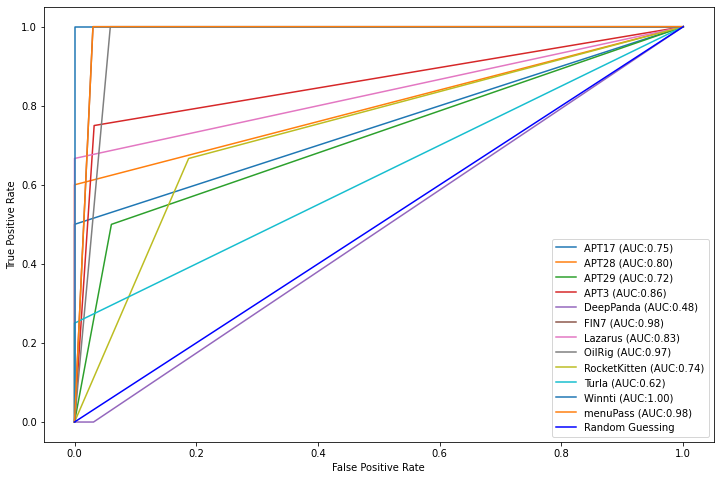

In [36]:
# Random Forrest NN model RUC_AUC Curves
ConfusionM = confusion_matrix(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
class_report = classification_report(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
print(f'confusion matrix: \n', ConfusionM)
print(f'classification_report: \n',class_report)

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= class_names

print(class_names)
for (idx, c_label) in enumerate(target):
  print(f"idx, c_label", idx, c_label)

y_labels = np.concatenate([y for x, y in test_ds], axis=-1)

y_hat_probs = df_and_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class2
def multiclass_roc_auc_score_2(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score_2(y_labels, y_hat_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


In [35]:
# Gradient Boosted  NN Model Metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

y_labels = test_ds.map(lambda x,y: y)
print(y_labels.unbatch)

y_labels = y_labels.as_numpy_iterator()

## Reduce to 1D Array
y_labels = np.concatenate([y for x, y in test_ds], axis=0)

y_hat_probs = gdb_df_and_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)


## accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_labels, y_hat_classes)
print('Accuracy: %f' % accuracy)

## precision tp / (tp + fp)
precision = precision_score(y_labels, y_hat_classes, average=None)
print('Precision (None): %f' % precision.sum())
precision = precision_score(y_labels, y_hat_classes, average='micro')
print('Precision (micro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'macro')
print('Precision (macro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'weighted')
print('Precision (weighted): %f' % precision)

## recall: tp / (tp + fn)
recall = recall_score(y_labels, y_hat_classes, average='micro')
print('Recall (micro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='macro')
print('Recall (macro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='weighted')
print('Recall (weighted): %f' % recall)

## f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_labels, y_hat_classes, average='micro')
print('F1 score (micro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='macro')
print('F1 score (macro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='weighted')
print('F1 score (weighted): %f' % f1)
 
## kappa
kappa = cohen_kappa_score(y_labels, y_hat_classes)
print('Cohens kappa: %f' % kappa)


## confusion matrix
matrix = confusion_matrix(y_labels, y_hat_classes)
print(matrix)

<bound method DatasetV2.unbatch of <MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>>
7/7 [==============================] - 0s 6ms/step
Accuracy: 0.657143
Precision (None): 8.750000
Precision (micro): 0.657143
Precision (macro): 0.729167
Precision (weighted): 0.790476
Recall (micro): 0.657143
Recall (macro): 0.716667
Recall (weighted): 0.657143
F1 score (micro): 0.657143
F1 score (macro): 0.664815
F1 score (weighted): 0.666190
Cohens kappa: 0.623318
[[1 0 0 1 0 0 0 0 0 0 0 0]
 [0 3 2 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 3 0 0 0 1 0 0 0 0]
 [0 0 0 0 2 0 0 0 1 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 2 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 0 0 0]
 [0 0 0 0 1 1 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]


In [ ]:
# Gradient Boosted model RUC_AUC Curves
ConfusionM = confusion_matrix(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
class_report = classification_report(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
print(f'confusion matrix: \n', ConfusionM)
print(f'classification_report: \n',class_report)

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= class_names

print(class_names)
for (idx, c_label) in enumerate(target):
  print(f"idx, c_label", idx, c_label)

y_labels = np.concatenate([y for x, y in test_ds], axis=-1)

y_hat_probs = df_and_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class2
def multiclass_roc_auc_score_2(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score_2(y_labels, y_hat_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


Compare it to the Neural Network alone:

In [37]:
print("Evaluation :", nn_model.evaluate(test_ds))

7/7 [==============================] - 0s 5ms/step - loss: 2.0844 - accuracy: 0.5429
Evaluation : [2.084425926208496, 0.5428571701049805]


# NN with BERT Encoder and DF trees

In [38]:
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer



In [39]:
bert_model_name = 'bert_en_wwm_uncased_L-24_H-1024_A-16'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "electra_large", "experts_pubmed", "experts_wiki_books", "experts_wiki_books_mnli", "experts_wiki_books_qnli", "experts_wiki_books_qqp", "experts_wiki_books_sst2", "experts_wiki_books_squad2", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'electra_large':
        'https://tfhub.dev/google/electra_large/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_pubmed_squad2':
        'https://tfhub.dev/google/experts/bert/pubmed/squad2/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'experts_wiki_books_mnli':
        'https://tfhub.dev/google/experts/bert/wiki_books/mnli/2',
    'experts_wiki_books_qnli':
        'https://tfhub.dev/google/experts/bert/wiki_books/qnli/2',
    'experts_wiki_books_qqp':
        'https://tfhub.dev/google/experts/bert/wiki_books/qqp/2',
    'experts_wiki_books_sst2':
        'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2',
    'experts_wiki_books_squad2':
        'https://tfhub.dev/google/experts/bert/wiki_books/squad2/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed_squad2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_mnli':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_qnli':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_qqp':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_sst2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_squad2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Build The Model

In [40]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(562, activation="relu")(net)
  net = tf.keras.layers.Dense(272, activation="tanh")(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(172, activation="tanh")(net)
  net = tf.keras.layers.Dropout(0.25)(net)
  net = tf.keras.layers.Dense(94, activation="tanh")(net)
  net = tf.keras.layers.Dense(len(class_names), activation="softmax", name='outputs')(net)
  return tf.keras.Model(text_input, net)

In [41]:
bert_nn_model = build_classifier_model()

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = 900
num_warmup_steps = 121

init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
bert_nn_model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"])

# Add callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc= ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

bert_nn_model.fit(x=train_ds, validation_data=test_ds, epochs=10, callbacks=[es,mc])
bert_nn_model.summary()

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 2.5958 - accuracy: 0.1133

41/41 [==============================] - 224s 5s/step - loss: 2.5958 - accuracy: 0.1133 - val_loss: 2.4141 - val_accuracy: 0.2000
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 2.0782 - accuracy: 0.3744

41/41 [==============================] - 185s 5s/step - loss: 2.0782 - accuracy: 0.3744 - val_loss: 2.0855 - val_accuracy: 0.3143
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 1.4671 - accuracy: 0.5616

41/41 [==============================] - 183s 4s/step - loss: 1.4671 - accuracy: 0.5616 - val_loss: 1.4331 - val_accuracy: 0.5143
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.7241

41/41 [==============================] - 184s 4s/step - loss: 0.9645 - accuracy: 0.7241 - val_loss: 1.7652 - val_accuracy: 0.4857
Epoch 5/10
41/41 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.8030

41/41 [==============================] - 187s 5s/step - loss: 0.7086 - accuracy: 0.8030 - val_loss: 1.5509 - val_accuracy: 0.6571
Epoch 6/10
41/41 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.8768

41/41 [==============================] - 187s 5s/step - loss: 0.4638 - accuracy: 0.8768 - val_loss: 1.9337 - val_accuracy: 0.6000
Epoch 6: early stopping
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'inp

In [44]:
bert_nn_model.fit(x=train_ds, validation_data=test_ds, epochs=4, callbacks=[es,mc])
bert_nn_model.summary()

Epoch 1/4
41/41 [==============================] - ETA: 0s - loss: 0.3077 - accuracy: 0.9064

41/41 [==============================] - 185s 5s/step - loss: 0.3077 - accuracy: 0.9064 - val_loss: 1.3975 - val_accuracy: 0.6286
Epoch 2/4
41/41 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.9212

41/41 [==============================] - 185s 5s/step - loss: 0.3054 - accuracy: 0.9212 - val_loss: 2.0743 - val_accuracy: 0.6286
Epoch 3/4
41/41 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.9360

41/41 [==============================] - 184s 5s/step - loss: 0.2860 - accuracy: 0.9360 - val_loss: 2.4121 - val_accuracy: 0.5429
Epoch 4/4
41/41 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9557

41/41 [==============================] - 183s 4s/step - loss: 0.2130 - accuracy: 0.9557 - val_loss: 2.1219 - val_accuracy: 0.6857
Epoch 4: early stopping
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'inp

In [45]:
df_and_bert_nn_model = tfdf.keras.RandomForestModel(preprocessing=bert_nn_model, check_dataset=False)
gdb_df_and_bert_nn_model = tfdf.keras.GradientBoostedTreesModel(preprocessing=bert_nn_model, check_dataset=False)

Use /tmp/tmpq96rizyf as temporary training directory


Use /tmp/tmp62dmdgq9 as temporary training directory


In [46]:
history_gdb = df_and_bert_nn_model.fit(x=train_ds)

print(history_gdb.history)

Reading training dataset...
Training dataset read in 0:00:54.968313. Found 203 examples.
Training model...
Model trained in 0:00:00.055440
Compiling model...
Model compiled.


{'num_examples': [203], 'accuracy': [0.9753694581280788], 'loss': [0.12584745479986217]}


In [47]:
history_gdb = gdb_df_and_bert_nn_model.fit(x=train_ds)

print(history_gdb.history)

Reading training dataset...
Training dataset read in 0:00:54.240352. Found 203 examples.
Training model...
Model trained in 0:00:10.935551
Compiling model...
Model compiled.
{'accuracy': [1.0], 'loss': [8.3137747424189e-06]}


In [48]:
df_and_bert_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", df_and_bert_nn_model.evaluate(test_ds))

7/7 [==============================] - 11s 1s/step - loss: 0.0000e+00 - accuracy: 0.6286
Evaluation: [0.0, 0.6285714507102966]


In [49]:
gdb_df_and_bert_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", gdb_df_and_bert_nn_model.evaluate(test_ds))

7/7 [==============================] - 11s 1s/step - loss: 0.0000e+00 - accuracy: 0.6000
Evaluation: [0.0, 0.6000000238418579]


# Model Metrics

In [50]:
# Random Forrest NN Model Metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

y_labels = test_ds.map(lambda x,y: y)
print(y_labels.unbatch)

y_labels = y_labels.as_numpy_iterator()

## Reduce to 1D Array
y_labels = np.concatenate([y for x, y in test_ds], axis=0)

y_hat_probs = df_and_bert_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)


## accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_labels, y_hat_classes)
print('Accuracy: %f' % accuracy)

## precision tp / (tp + fp)
precision = precision_score(y_labels, y_hat_classes, average=None)
print('Precision (None): %f' % precision.sum())
precision = precision_score(y_labels, y_hat_classes, average='micro')
print('Precision (micro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'macro')
print('Precision (macro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'weighted')
print('Precision (weighted): %f' % precision)

## recall: tp / (tp + fn)
recall = recall_score(y_labels, y_hat_classes, average='micro')
print('Recall (micro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='macro')
print('Recall (macro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='weighted')
print('Recall (weighted): %f' % recall)

## f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_labels, y_hat_classes, average='micro')
print('F1 score (micro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='macro')
print('F1 score (macro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='weighted')
print('F1 score (weighted): %f' % f1)
 
## kappa
kappa = cohen_kappa_score(y_labels, y_hat_classes)
print('Cohens kappa: %f' % kappa)


## confusion matrix
matrix = confusion_matrix(y_labels, y_hat_classes)
print(matrix)

<bound method DatasetV2.unbatch of <MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>>
7/7 [==============================] - 10s 1s/step
Accuracy: 0.628571
Precision (None): 8.650000
Precision (micro): 0.628571
Precision (macro): 0.720833
Precision (weighted): 0.744286
Recall (micro): 0.628571
Recall (macro): 0.688889
Recall (weighted): 0.628571
F1 score (micro): 0.628571
F1 score (macro): 0.648503
F1 score (weighted): 0.635560
Cohens kappa: 0.590090
[[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 3 1 0 0 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 3 1 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [1 1 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 2 1 0 0 0]
 [1 1 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]


confusion matrix: 
 [[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 3 1 0 0 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 3 1 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [1 1 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 2 1 0 0 0]
 [1 1 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]
classification_report: 
               precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.60      0.60      0.60         5
           2       0.50      0.50      0.50         2
           3       0.75      0.75      0.75         4
           4       0.50      0.67      0.57         3
           5       1.00      1.00      1.00         2
           6       0.80      0.67      0.73         6
           7       0.25      1.00      0.40         1
           8       1.00      0.33      0.50         3
           9       1.00      0.25      0.40         4
          10       1.00      1.00  

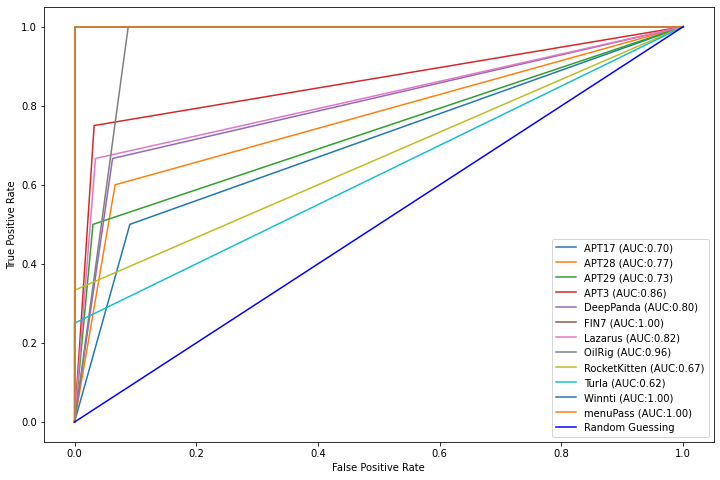

In [51]:
# Random Forrest NN model RUC_AUC Curves
ConfusionM = confusion_matrix(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
class_report = classification_report(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
print(f'confusion matrix: \n', ConfusionM)
print(f'classification_report: \n',class_report)

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= class_names

print(class_names)
for (idx, c_label) in enumerate(target):
  print(f"idx, c_label", idx, c_label)

y_labels = np.concatenate([y for x, y in test_ds], axis=-1)

y_hat_probs = df_and_bert_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class2
def multiclass_roc_auc_score_2(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score_2(y_labels, y_hat_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()



In [52]:
# Gradient Boosted NN Model Metrics
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

y_labels = test_ds.map(lambda x,y: y)
print(y_labels.unbatch)

y_labels = y_labels.as_numpy_iterator()

## Reduce to 1D Array
y_labels = np.concatenate([y for x, y in test_ds], axis=0)

y_hat_probs = gdb_df_and_bert_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)


## accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_labels, y_hat_classes)
print('Accuracy: %f' % accuracy)

## precision tp / (tp + fp)
precision = precision_score(y_labels, y_hat_classes, average=None)
print('Precision (None): %f' % precision.sum())
precision = precision_score(y_labels, y_hat_classes, average='micro')
print('Precision (micro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'macro')
print('Precision (macro): %f' % precision)
precision = precision_score(y_labels, y_hat_classes, average= 'weighted')
print('Precision (weighted): %f' % precision)

## recall: tp / (tp + fn)
recall = recall_score(y_labels, y_hat_classes, average='micro')
print('Recall (micro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='macro')
print('Recall (macro): %f' % recall)
recall = recall_score(y_labels, y_hat_classes, average='weighted')
print('Recall (weighted): %f' % recall)

## f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_labels, y_hat_classes, average='micro')
print('F1 score (micro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='macro')
print('F1 score (macro): %f' % f1)
f1 = f1_score(y_labels, y_hat_classes, average='weighted')
print('F1 score (weighted): %f' % f1)
 
## kappa
kappa = cohen_kappa_score(y_labels, y_hat_classes)
print('Cohens kappa: %f' % kappa)


## confusion matrix
matrix = confusion_matrix(y_labels, y_hat_classes)
print(matrix)

<bound method DatasetV2.unbatch of <MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>>
7/7 [==============================] - 10s 1s/step
Accuracy: 0.600000
Precision (None): 8.276190
Precision (micro): 0.600000
Precision (macro): 0.689683
Precision (weighted): 0.728163
Recall (micro): 0.600000
Recall (macro): 0.654167
Recall (weighted): 0.600000
F1 score (micro): 0.600000
F1 score (macro): 0.612963
F1 score (weighted): 0.612698
Cohens kappa: 0.560144
[[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 3 1 0 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0]
 [2 0 0 2 0 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix: 
 [[1 0 0 0 0 0 1 0 0 0 0 0]
 [0 3 1 0 0 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0]
 [2 0 0 2 0 0 0 0 0 0 0 0]
 [1 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0]
 [0 1 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 2]]
classification_report: 
               precision    recall  f1-score   support

           0       0.14      0.50      0.22         2
           1       0.60      0.60      0.60         5
           2       0.50      0.50      0.50         2
           3       1.00      0.50      0.67         4
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         2
           6       0.83      0.83      0.83         6
           7       0.20      1.00      0.33         1
           8       0.00      0.00      0.00         3
           9       1.00      0.25      0.40         4
          10       1.00      1.00  

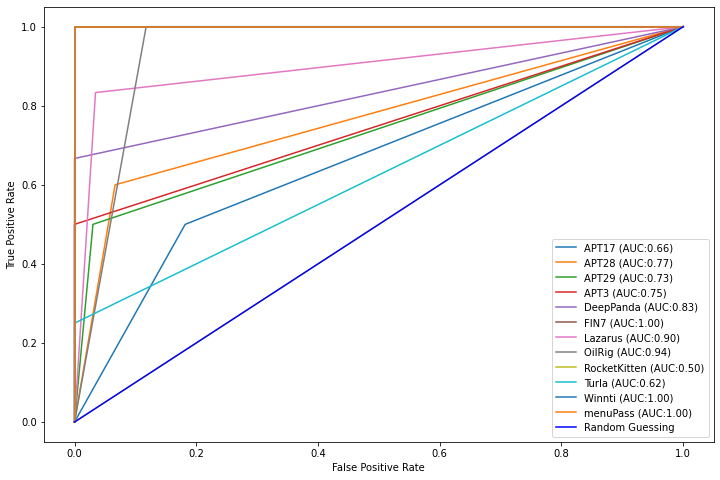

In [53]:
# Gradient Boosted NN model RUC_AUC Curves
ConfusionM = confusion_matrix(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
class_report = classification_report(list(y_labels), y_hat_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
print(f'confusion matrix: \n', ConfusionM)
print(f'classification_report: \n',class_report)

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= class_names

print(class_names)
for (idx, c_label) in enumerate(target):
  print(f"idx, c_label", idx, c_label)

y_labels = np.concatenate([y for x, y in test_ds], axis=-1)

y_hat_probs = gdb_df_and_bert_nn_model.predict(test_ds)

y_hat_classes = y_hat_probs.argmax(axis=-1)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class2
def multiclass_roc_auc_score_2(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score_2(y_labels, y_hat_classes))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

